In [1]:
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

#Store Data Variables
import json
with open('feature_data.json', 'r') as f:
 features = json.load(f)

from scipy.io import loadmat
train_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')['train_idx'].flatten()
query_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')['query_idx'].flatten()
labels = loadmat('cuhk03_new_protocol_config_labeled.mat')['labels'].flatten()
gallery_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')['gallery_idx'].flatten()
filelist = loadmat('cuhk03_new_protocol_config_labeled.mat')['filelist'].flatten()
camId = loadmat('cuhk03_new_protocol_config_labeled.mat')['camId'].flatten()

In [9]:

X = np.array(features)
y = np.array(labels)
filelist = np.array(filelist)
camId = np.array(camId)



In [10]:
mask_train = np.array(train_idxs).ravel()
mask_query = np.array(query_idxs).ravel()
mask_gallery = np.array(gallery_idxs).ravel()

mask_train = np.subtract(mask_train, 1)
mask_query = np.subtract(mask_query, 1)
mask_gallery = np.subtract(mask_gallery, 1)


X_train, X_query, X_gallery = X[mask_train, :], X[mask_query, :], X[mask_gallery, :]
y_train, y_query, y_gallery = y[mask_train], y[mask_query], y[mask_gallery]
filelist_train, filelist_query, filelist_gallery = filelist[mask_train], filelist[mask_query], filelist[mask_gallery]
camId_train, camId_query, camId_gallery = camId[mask_train], camId[mask_query], camId[mask_gallery]


In [11]:
def get_acc_score(y_valid, y_q, tot_label_occur):
    recall = 0
    true_positives = 0
    
    k = 0
    
    max_rank = 30
    
    rank_A = np.zeros(max_rank)
    AP_arr = np.zeros(11)
    
    while (recall < 1) or (k < max_rank):
        
        if (y_valid[k] == y_q):
            
            true_positives = true_positives + 1
            recall = true_positives/tot_label_occur
            precision = true_positives/(k+1)
            
            AP_arr[round((recall-0.05)*10)] = precision
            
            for n in range (k, max_rank):
                rank_A[n] = 1
            
        k = k+1
        
    max_precision = 0
    for i in range(10, -1, -1):
        max_precision = max(max_precision, AP_arr[i])
        AP_arr[i] = max_precision
    
    AP_ = AP_arr.sum()/11
    
    return AP_, rank_A

In [12]:
from scipy.spatial import distance
from sklearn.metrics import pairwise


def evaluate_metric(X_query, camId_query, y_query, X_gallery, camId_gallery, y_gallery, metric = 'euclidian', parameters = None):

    rank_accuracies = []
    AP = []

    # Break condition for testing
    #q = 0

    for query, camId_q, y_q in zip(X_query, camId_query, y_query):
        q_g_dists = []
        y_valid = []
        for gallery, camId_g, y_g  in zip(X_gallery, camId_gallery, y_gallery):
            if ((camId_q == camId_g) and (y_q == y_g)):
                continue
            else:
                if metric == 'euclidian':
                    dist = distance.euclidean(query, gallery)
                elif metric == 'sqeuclidean':
                    dist = distance.sqeuclidean(query, gallery)
                elif metric == 'mahalanobis':
                    dist = distance.mahalanobis(query, gallery, parameters)
                else:
                    raise NameError('Specified metric not supported')           
                q_g_dists.append(dist)
                y_valid.append(y_g)
    
        tot_label_occur = y_valid.count(y_q)
    
        q_g_dists = np.array(q_g_dists)
        y_valid = np.array(y_valid)
    
        _indexes = np.argsort(q_g_dists)
    
        # Sorted distances and labels
        q_g_dists, y_valid = q_g_dists[_indexes], y_valid[_indexes]
    
        AP_, rank_A = get_acc_score(y_valid, y_q, tot_label_occur)
    
        AP.append(AP_)
        
        rank_accuracies.append(rank_A)
    
        #if q  > 5:
        #    break
        #q = q+1

    rank_accuracies = np.array(rank_accuracies)

    total = rank_accuracies.shape[0]
    rank_accuracies = rank_accuracies.sum(axis = 0)
    rank_accuracies = np.divide(rank_accuracies, total)

    i = 0
    print ('Accuracies by Rank:')
    while i < rank_accuracies.shape[0]:
        print('Rank ', i+1, ' = %.2f%%' % (rank_accuracies[i] * 100), '\t',
              'Rank ', i+2, ' = %.2f%%' % (rank_accuracies[i+1] * 100), '\t',
              'Rank ', i+3, ' = %.2f%%' % (rank_accuracies[i+2] * 100), '\t',
              'Rank ', i+4, ' = %.2f%%' % (rank_accuracies[i+3] * 100), '\t',
              'Rank ', i+5, ' = %.2f%%' % (rank_accuracies[i+4] * 100))
        i = i+5

    AP = np.array(AP)

    mAP = AP.sum()/AP.shape[0]
    print('mAP = %.2f%%' % (mAP * 100))
    
    return rank_accuracies, mAP

    
        
    

In [13]:
rank_accuracies_l_2 = []
mAP_l_2 = []
metric_l_2 = []

In [26]:
#Obtained from other file

rank_accuracy_base = np.array([47.00, 54.57, 59.64, 63.93, 66.86, 69.29, 71.14, 72.36, 73.71, 74.93, 75.86, 76.79, 77.71, 78.50, 79.07, 79.86, 80.64, 81.57, 82.29, 83.21, 83.50, 83.71, 84.00, 84.29, 84.79, 85.29, 85.64, 85.93, 86.07, 86.36])


In [ ]:

#Mahalanobis - inverse covariance


V = np.cov(X_train.T)

print (V.shape)

VI = np.linalg.inv(V)

print (VI.shape)



rank_accuracies, mAP = evaluate_metric(X_query, camId_query, y_query,
                                       X_gallery, camId_gallery, y_gallery,
                                       metric ='mahalanobis',
                                       parameters = VI)

rank_accuracies_l_2.append(rank_accuracies)
mAP_l_2.append(mAP)
metric_l_2.append('Mahalanobis - Covariance')

(2048, 2048)
(2048, 2048)
Accuracies by Rank:
Rank  1  = 30.93% 	 Rank  2  = 36.14% 	 Rank  3  = 39.79% 	 Rank  4  = 43.00% 	 Rank  5  = 45.50%
Rank  6  = 46.93% 	 Rank  7  = 47.79% 	 Rank  8  = 48.71% 	 Rank  9  = 49.57% 	 Rank  10  = 50.14%
Rank  11  = 50.71% 	 Rank  12  = 51.57% 	 Rank  13  = 51.93% 	 Rank  14  = 52.71% 	 Rank  15  = 53.50%
Rank  16  = 54.21% 	 Rank  17  = 54.71% 	 Rank  18  = 55.29% 	 Rank  19  = 55.57% 	 Rank  20  = 55.93%
Rank  21  = 56.64% 	 Rank  22  = 56.64% 	 Rank  23  = 57.14% 	 Rank  24  = 57.29% 	 Rank  25  = 57.71%
Rank  26  = 58.00% 	 Rank  27  = 58.29% 	 Rank  28  = 58.64% 	 Rank  29  = 59.07% 	 Rank  30  = 59.21%
mAP = 24.26%


In [16]:
from metric_learn import MMC_Supervised
from sklearn.decomposition import PCA

#Mahalanobis - learnt - reduced set


pca = PCA(n_components=150)
X_train_pca = pca.fit_transform(X_train)
X_query_pca = pca.transform(X_query)
X_gallery_pca = pca.transform(X_gallery)

mmc = MMC_Supervised(max_iter=50)
mmc.fit(X_train_pca[0:150], y_train[0:150])



M = mmc.metric()

print ('Metric learnt')


rank_accuracies, mAP = evaluate_metric(X_query_pca, camId_query, y_query,
                                       X_gallery_pca, camId_gallery, y_gallery,
                                       metric ='mahalanobis',
                                       parameters = M)

rank_accuracies_l_2.append(rank_accuracies)
mAP_l_2.append(mAP)
metric_l_2.append('Learnt Mahalanobis (Red. Set)')


/anaconda3/lib/python3.6/site-packages/metric_learn/constraints.py:62: UserWarning: Only generated 1280 positive constraints (requested 5120)
  len(ab), 'positive' if same_label else 'negative', num_constraints))


Metric learnt
Accuracies by Rank:
Rank  1  = 46.79% 	 Rank  2  = 54.50% 	 Rank  3  = 59.57% 	 Rank  4  = 64.29% 	 Rank  5  = 67.43%
Rank  6  = 69.50% 	 Rank  7  = 71.07% 	 Rank  8  = 72.21% 	 Rank  9  = 73.57% 	 Rank  10  = 74.93%
Rank  11  = 75.79% 	 Rank  12  = 77.00% 	 Rank  13  = 77.93% 	 Rank  14  = 78.86% 	 Rank  15  = 79.36%
Rank  16  = 79.93% 	 Rank  17  = 80.29% 	 Rank  18  = 81.43% 	 Rank  19  = 81.93% 	 Rank  20  = 82.93%
Rank  21  = 83.43% 	 Rank  22  = 83.93% 	 Rank  23  = 84.21% 	 Rank  24  = 84.43% 	 Rank  25  = 84.79%
Rank  26  = 85.21% 	 Rank  27  = 85.64% 	 Rank  28  = 85.71% 	 Rank  29  = 86.00% 	 Rank  30  = 86.36%
mAP = 46.56%


In [24]:
from metric_learn import LMNN

lmnn = LMNN(k=3, learn_rate=1e-6, max_iter=50)
lmnn.fit(X_train_pca, y_train)


M = lmnn.metric()

print ('Metric learnt')



rank_accuracies, mAP = evaluate_metric(X_query_pca, camId_query, y_query,
                                       X_gallery_pca, camId_gallery, y_gallery,
                                       metric ='mahalanobis',
                                       parameters = M)

rank_accuracies_l_2.append(rank_accuracies)
mAP_l_2.append(mAP)
metric_l_2.append('Learnt LMNN')

/anaconda3/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


Metric learnt
Accuracies by Rank:
Rank  1  = 43.71% 	 Rank  2  = 52.43% 	 Rank  3  = 57.71% 	 Rank  4  = 61.29% 	 Rank  5  = 64.07%
Rank  6  = 66.43% 	 Rank  7  = 68.29% 	 Rank  8  = 69.71% 	 Rank  9  = 71.71% 	 Rank  10  = 72.71%
Rank  11  = 73.86% 	 Rank  12  = 74.93% 	 Rank  13  = 75.86% 	 Rank  14  = 76.29% 	 Rank  15  = 76.79%
Rank  16  = 77.36% 	 Rank  17  = 78.00% 	 Rank  18  = 78.86% 	 Rank  19  = 79.29% 	 Rank  20  = 79.79%
Rank  21  = 80.29% 	 Rank  22  = 80.86% 	 Rank  23  = 81.43% 	 Rank  24  = 82.00% 	 Rank  25  = 82.36%
Rank  26  = 83.14% 	 Rank  27  = 83.50% 	 Rank  28  = 83.86% 	 Rank  29  = 84.21% 	 Rank  30  = 84.71%
mAP = 43.01%


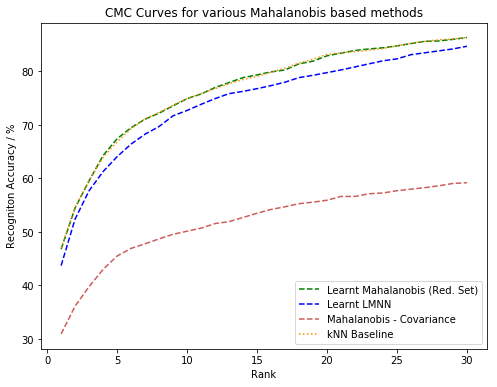

In [29]:
plt.figure(figsize=(8.0, 6.0))
color_list = ['green', 'blue', 'red', 'purple', 'orange', 'magenta', 'cyan', 'black', 'indianred', 'lightseagreen', 'gold', 'lightgreen']
for i in range(len(metric_l_2)):
    plt.plot(np.arange(1, 31), 100*rank_accuracies_l_2[i], color=color_list[i], linestyle='dashed', label=metric_l_2[i])
plt.plot(np.arange(1, 31), rank_accuracy_base, color='darkorange', linestyle=':', label='kNN Baseline')
plt.title('CMC Curves for various Mahalanobis based methods')
plt.xlabel('Rank')
plt.ylabel('Recogniton Accuracy / %')
plt.legend(loc='best')